In [1]:
!uv sync
%load_ext autoreload 
%autoreload 2  
# imported functions are re-imported if they are changed

Resolved 153 packages in 6ms
Audited 150 packages in 0.50ms


In [2]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import planetary_computer
import pystac_client
import stackstac

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# MODIS Land surface temperature
The product we're using (MOD11A1 / MYD11A1) contains both Aqua and Terra data. These satellites are sun-synchronous, meaning they pass over the same location at the same time each day. To find this time for our bounding box, we can use the [MODIS overpass predictor](https://oceandata.sci.gsfc.nasa.gov/overpass_pred/).

This will be important in matching the satellite images with the station temperature data. 

In [4]:
# http://bboxfinder.com/
bbox_WSEN = 17.896010,-34.484990,19.598891,-33.159334  

# a single year to get an idea of number of missing data
datetime = "2019-01-01/2019-12-31"
# https://planetarycomputer.microsoft.com/dataset/modis-11A1-061
product = "modis-11A1-061"

# perform a simple search for MODIS data
search = catalog.search(
    collections=[product],
    bbox=bbox_WSEN,
    datetime=datetime)

# retrieve the items into a list-type object (FeatureCollection)
items = search.item_collection()
# these items are simply a standard way of storing metadata of geo-spatial data
# It contains lat/lon, datetime, and other metadata + the link to the actual data

In [7]:
# the stackstac library is able to open the data from the links in the items 
# and stack them into a single xarray dataset into the coordinate reference system of choice
da_lst = stackstac.stack(
    items,
    assets=['LST_Day_1km', 'LST_Night_1km'],
    bounds_latlon=bbox_WSEN,  # bounding boxes are always in WSEN order
    epsg=4326,  # WGS84 coordinate reference system (lat/lon)
    resolution=0.01,  # 1/100th of a degree is about 1km
)[:10].load()

In [85]:
da = da_lst.drop('time').rename(start_datetime='time')  # remove time and rename start_datetime to time
da['time'] = pd.to_datetime(da['time'].astype('datetime64'))  # da.start_datetime is text, so here we convert it to np.datetime64
da = da.assign_attrs(long_name='Land Surface Temperature', units='K').sortby('time')  # add metadata to make plot labels nicer

/var/folders/4n/tkh2q3cn5fl09xv_kq_17v8c0000gn/T/ipykernel_92969/3885901523.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da = da_lst.drop('time').rename(start_datetime='time')  # remove time and rename start_datetime to time
/var/folders/4n/tkh2q3cn5fl09xv_kq_17v8c0000gn/T/ipykernel_92969/3885901523.py:1: UserWarning: rename 'start_datetime' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da_lst.drop('time').rename(start_datetime='time')  # remove time and rename start_datetime to time
/Users/luke/Work/Students/benedict_ejelonu/data-exploration/.venv/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:234: UserWarning: no explicit representation of timezones available for np.datetime64
  return data.astype(dtype, **kwargs)


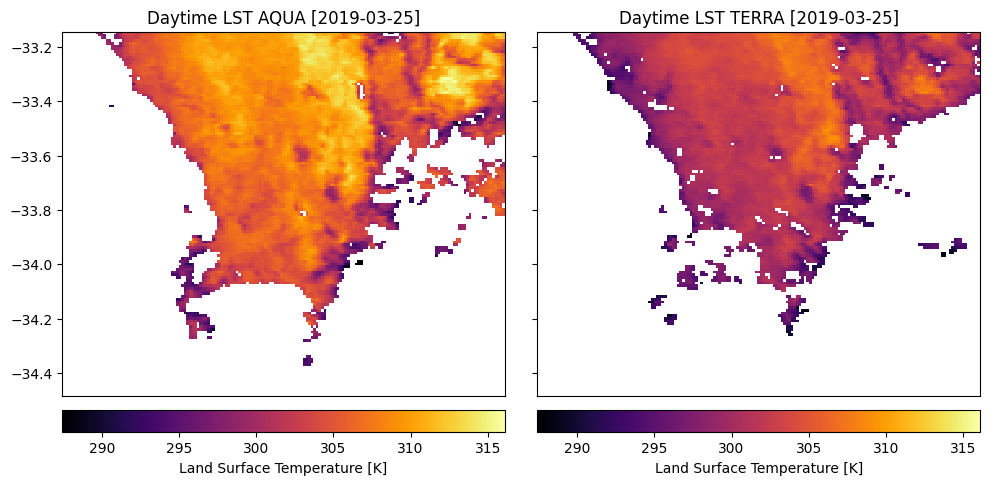

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

da1 = da.isel(time=230, band=0)  # isel = index based selection, here we select the 11th last time step
da2 = da.isel(time=231, band=0)  # we also slect the first band (daytime)

props = dict(cmap='inferno', robust=False, cbar_kwargs=dict(location='bottom', pad=0.03))
img0 = da1.plot.imshow(ax=axs[0], **props)
img1 = da2.plot.imshow(ax=axs[1], **props)

img1.set_clim(img0.get_clim())  # make sure the color limits are the same

[ax.set_xticks([]) for ax in axs]
[ax.set_xlabel('') for ax in axs]
[ax.set_ylabel('') for ax in axs]

axs[0].set_title(f'Daytime LST {da1.platform.item().upper()} [{da1.time.dt.strftime("%Y-%m-%d").item()}]')
axs[1].set_title(f'Daytime LST {da2.platform.item().upper()} [{da2.time.dt.strftime("%Y-%m-%d").item()}]')

fig.tight_layout(w_pad=2)

# Cloud cover impact

Here we check how necessary it would actually be to do in-painting since SA is a sunny place 🌞

In [87]:
coverage_pixels = da.count(dim=['x', 'y'])  # how many pixels are there for each time step
total_pixels = coverage_pixels.max(['time', 'band']).item()  # the maximum number of pixels at any time step

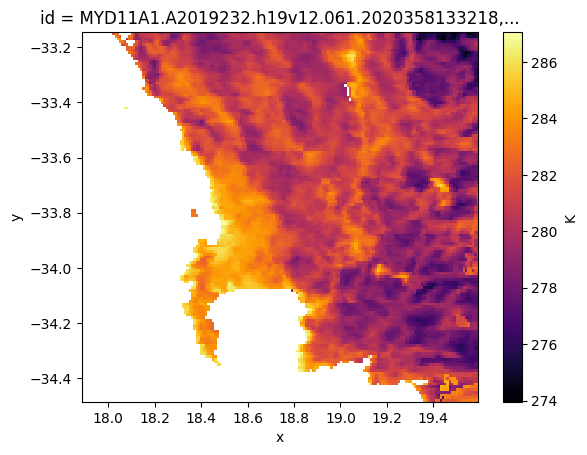

In [88]:
idx_max = coverage_pixels.max('band').idxmax('time')
da.sel(time=idx_max).isel(time=0, band=1).plot.imshow(cmap='inferno', robust=False, cbar_kwargs=dict(label='K'))

In [114]:
drop_coords = [k for k in da_lst.coords.keys() if (str(k).startswith('proj') or str(k).startswith('raster'))]
da_lst.attrs = dict(long_name='Land Surface Temperature', units='K')
ds = da_lst.to_dataset(name='modis_LST').drop(drop_coords)
ds.to_netcdf('modis_LST.nc', encoding={k: {'zlib': 1} for k in ds.data_vars}, engine='h5netcdf')

/var/folders/4n/tkh2q3cn5fl09xv_kq_17v8c0000gn/T/ipykernel_92969/1390675323.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = da_lst.to_dataset(name='modis_LST').drop(drop_coords)


In [172]:
(  # find the mean cloud cover for cloudy days
    (coverage_pixels / total_pixels)  # fraction of time step with data
    .where(lambda x: 
           (x < 0.95)  # filter out cloudless days
           & 
           (x > 0)  # filter out days with no data
        )
    .mean('time')  # average over time
).rename('LST').to_series().round(2)

band
LST_Day_1km      0.50
LST_Night_1km    0.62
Name: LST, dtype: float64

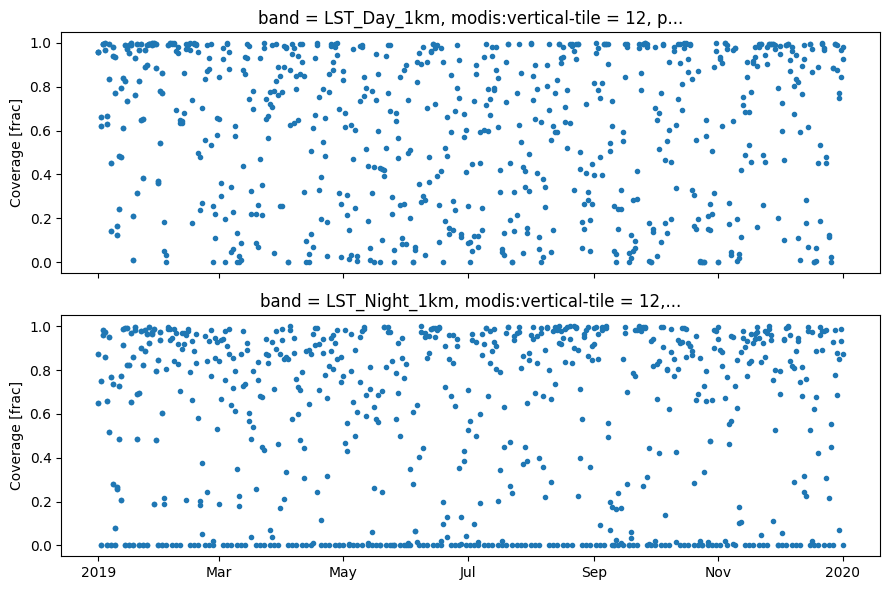

In [180]:
fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

da_coverage = coverage_pixels.pipe(lambda x: x / total_pixels)

da_coverage.sel(band='LST_Day_1km').plot(lw=0, marker='.', ax=axs[0])
da_coverage.sel(band='LST_Night_1km').plot(lw=0, marker='.', ax=axs[1])

[ax.set_xlabel('') for ax in axs] 
[ax.set_ylabel('Coverage [frac]') for ax in axs]

fig.tight_layout()